# **Распознавание жестов рук**

# Подготовка данных

Импортируем необходимые библиотеки.

In [ ]:
import cv2
import io
import glob
import html
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from base64 import b64decode, b64encode
from IPython.display import display, Javascript, Image
from collections import Counter
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from pandas.core.common import flatten
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchsummary import summary
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Загрузим датасет с изображениями.

In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog

100% 2.13G/2.13G [01:33<00:00, 28.3MB/s]
100% 2.13G/2.13G [01:33<00:00, 24.5MB/s]


In [ ]:
!unzip leapgestrecog

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapges

In [ ]:
data_root = '/content/leapGestRecog'

Выведем список классов.

In [ ]:
tmp_ds = ImageFolder(data_root + '/00')
classes_name = tmp_ds.classes
classes_name

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

Представлена база данных распознавания жестов рук, состоящая из набора изображений в ближнем инфракрасном диапазоне, полученных с помощью датчика Leap Motion. База данных содержит 10 различных жестов рук, которые выполняли 10 разных людей (5 мужчин и 5 женщин).

В датасете представлено 10 классов, которые характеризуют жесты на фото:

'01_palm' – ладонь,

 '02_l' – буква l,

 '03_fist' – цифра один,

 '04_fist_moved' – движение кулака,

 '05_thumb' - нажимание,

 '06_index' - индекс,

 '07_ok' - ok,

 '08_palm_moved' – движение ладони,

 '09_c' – буква с,

 '10_down' – движение вниз.


Сделаем несколько преобразований изображений для дальнейшей работы: преобразуем изображение в оттенки серого, приведем изображения к одному размеру, сделаем случайные горизонтальные переворачивания и случайные повороты для внесения большего разнообразия в данные.

In [ ]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=3), # трансформации
                         tt.Resize([128, 128]),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=3), tt.Resize([128, 128]), tt.ToTensor()])

Создадим датасет.

In [ ]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(data_root):
    train_ds = ImageFolder(os.path.join(data_root, dir), train_tfms)
    test_ds = ImageFolder(os.path.join(data_root, dir), test_tfms)
    train_ds_list.append(train_ds)
    test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

Проверим количество изображений в данных для обучения и тестирования.

In [ ]:
len(train_ds)

20000

In [ ]:
len(test_ds)

20000

Также выведем количество изображений по классам, чтобы убедиться в корректном формировании датасета.

In [ ]:
train_counts = Counter([label for _, label in train_ds])
print(train_counts)

Counter({0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 2000, 6: 2000, 7: 2000, 8: 2000, 9: 2000})


Создадим объекты DataLoader для загрузки данных из датасета и создание батчей для обучения.

In [ ]:
batch_size = 32

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2) # создание DataLoader
test_loader = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

Создадим функцию, которая будет выводить номер и название класса.

In [ ]:
def digit_to_classname(digit):
    for idx, itm in enumerate(classes_name):
        if idx == digit:
            return itm

Просмотрим одно из изображений из train_loader  и убедимся, что класс соответствует изображению.

torch.Size([3, 128, 128])
tensor(6) 07_ok


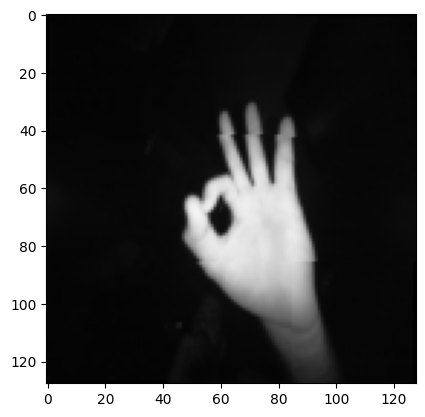

In [ ]:
for img, l in train_loader:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
    break

Создадим функцию для просмотра набора случайных изображений.

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


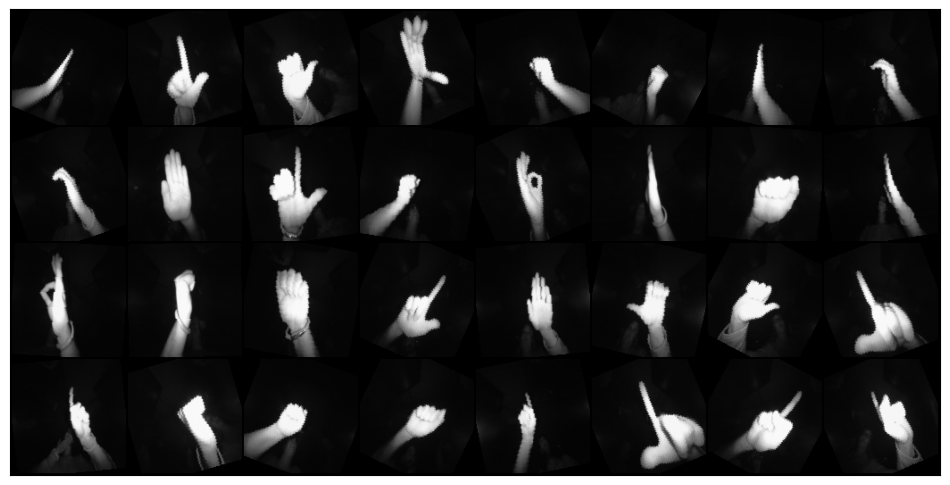

In [ ]:
show_batch(train_loader)

# Создание модели

Для обучения будем использовать resnet50 с предобученными весами, так как модель обеспечивает оптимальный баланс между высокой точностью (благодаря остаточным связям, решающим проблему затухающих градиентов) и вычислительной эффективностью, что делает ее универсальным выбором для большинства задач компьютерного зрения.

Загрузим предобученную модель.


In [ ]:
model = models.resnet50(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 68.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
summary(model.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Модель имеет 25,557,032 параметров. На выходе модель имеет 1000 классов.
Заморозим веса, которые идут до последнего слоя.


In [ ]:
for param in list(model.parameters())[:]:
    param.requires_grad = False

Заменим последний слой модели, чтобы на выходе вместо 1000 классов получилось 10.

In [ ]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(classes_name))

summary(model.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Остается 20,490 параметров для обучения.

Пройдемся по параметрам в цикле: если нужно считать градиент, веса добавляем в список, оптимизатор будет обучаться только на них.

In [ ]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

Будем проводить обучение на 5 эпохах. В процессе обучения будет выводиться статистика.



In [ ]:
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()

        if i % 300 == 0:
            model.eval()

            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(test_loader):

                test_outputs = model(data[0].to(device))
                test_running_total += len(data[1].to(device))
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        model.train()

print('Training is finished!')

Epoch [1/5]. Step [1/625]. Loss: 0.073. Acc: 0.062. Test acc: 0.137
Epoch [1/5]. Step [301/625]. Loss: 0.025. Acc: 0.762. Test acc: 0.163
Epoch [1/5]. Step [601/625]. Loss: 0.014. Acc: 0.861. Test acc: 0.217
Epoch [2/5]. Step [1/625]. Loss: 0.016. Acc: 0.812. Test acc: 0.226
Epoch [2/5]. Step [301/625]. Loss: 0.012. Acc: 0.870. Test acc: 0.254
Epoch [2/5]. Step [601/625]. Loss: 0.010. Acc: 0.891. Test acc: 0.190
Epoch [3/5]. Step [1/625]. Loss: 0.010. Acc: 0.906. Test acc: 0.231
Epoch [3/5]. Step [301/625]. Loss: 0.010. Acc: 0.894. Test acc: 0.196
Epoch [3/5]. Step [601/625]. Loss: 0.010. Acc: 0.899. Test acc: 0.220
Epoch [4/5]. Step [1/625]. Loss: 0.004. Acc: 1.000. Test acc: 0.212
Epoch [4/5]. Step [301/625]. Loss: 0.009. Acc: 0.898. Test acc: 0.203
Epoch [4/5]. Step [601/625]. Loss: 0.008. Acc: 0.911. Test acc: 0.161
Epoch [5/5]. Step [1/625]. Loss: 0.012. Acc: 0.906. Test acc: 0.201
Epoch [5/5]. Step [301/625]. Loss: 0.008. Acc: 0.906. Test acc: 0.169
Epoch [5/5]. Step [601/625]. L

Видим, что с каждой эпохой Loss постепенно снижается, качество растет.
Сохраним модель.


In [ ]:
torch.save(model, './detection_model.pth')

Загрузим модель для использования.

In [ ]:
net = torch.load('./detection_model.pth', map_location=device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Проверим модель на тестовых данных. Для этого выведем несколько изображений вместе с истинным и предсказанным классом.

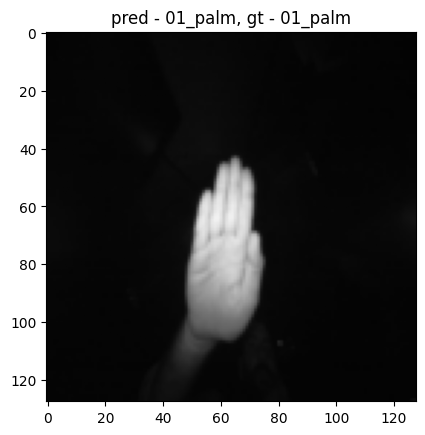

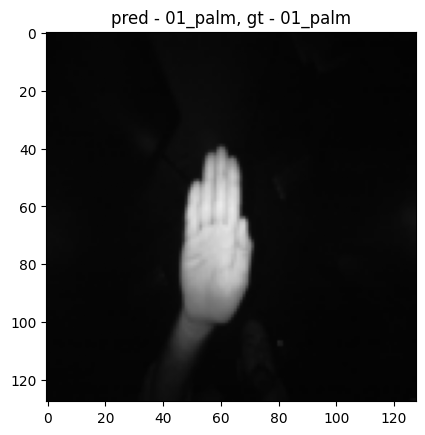

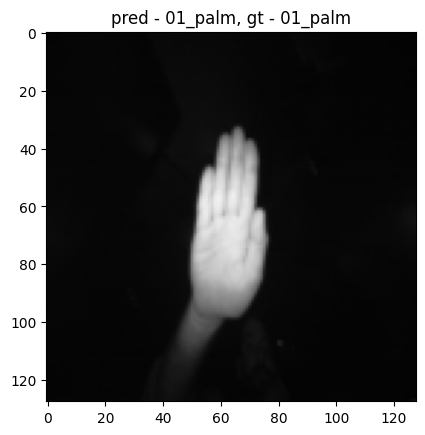

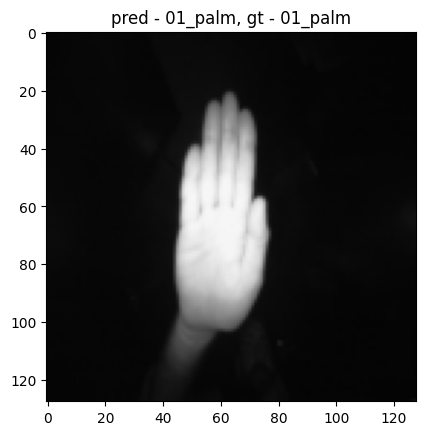

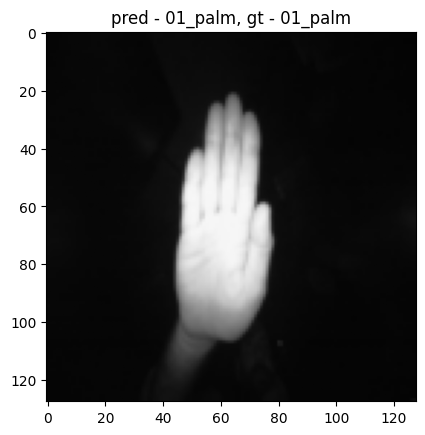

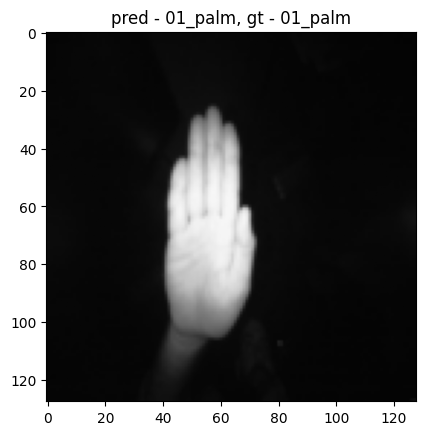

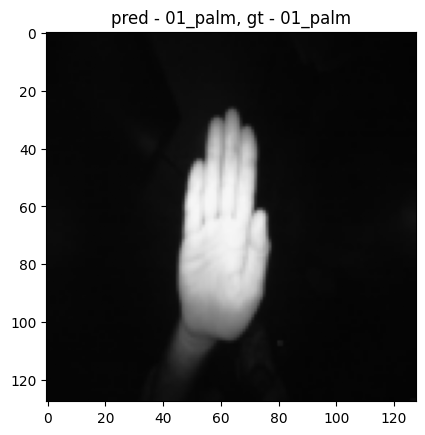

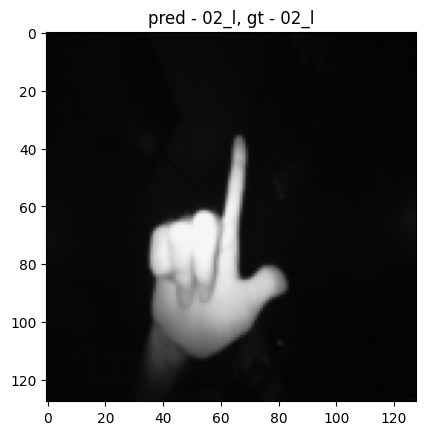

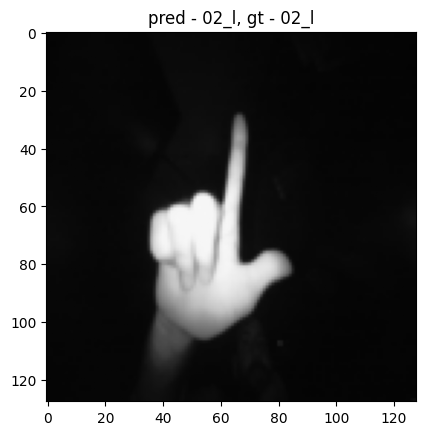

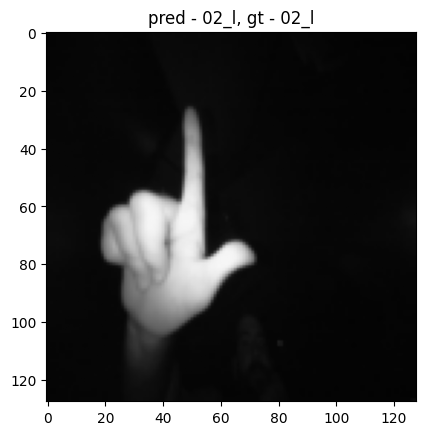

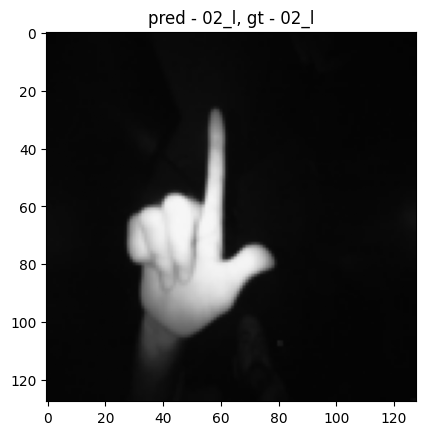

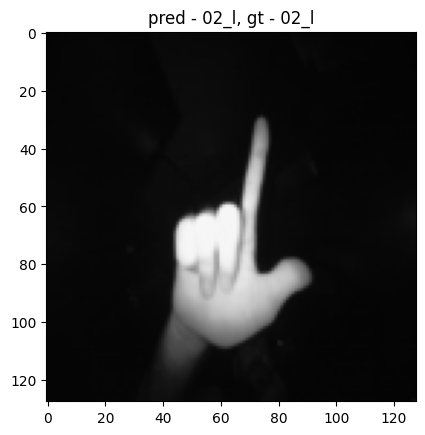

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>10:
            break

Модель правильно распознает жесты. Проверим модель на реальных фото.

# Работа модели на фото с веб-камеры

Используем фрагмент кода Google Colab для захвата изображения с веб-камеры.

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Создадим несколько фото.

<IPython.core.display.Javascript object>

Saved to photo.jpg


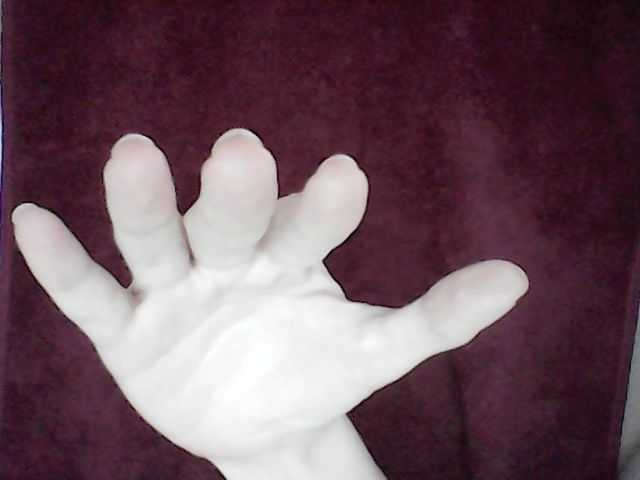

In [ ]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
img_data_path = '/content/photo'
test_image_paths = []
for data_path in glob.glob(img_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))
test_image_paths = list(flatten(test_image_paths))

print("Test image size: {}".format(len(test_image_paths)))

Test image size: 4


In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes_name)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = image/255.0
        image = image.transpose((2, 0, 1))

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]

        return image, label

Создадим датасет из фотографий.

In [ ]:
img_dataset = LandmarkDataset(test_image_paths, test_tfms)

In [ ]:
img_loader = DataLoader(img_dataset, batch_size=1, shuffle=True)

In [ ]:
next(iter(img_loader))[0].shape

torch.Size([1, 3, 128, 128])

Предскажем классы по фото.

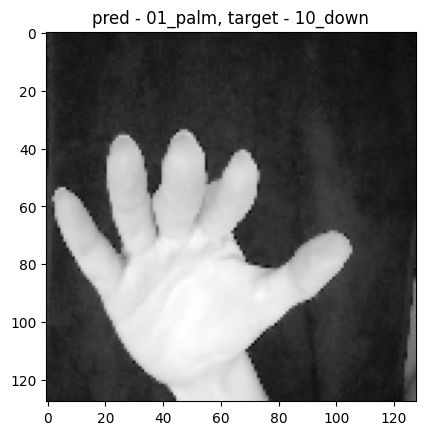

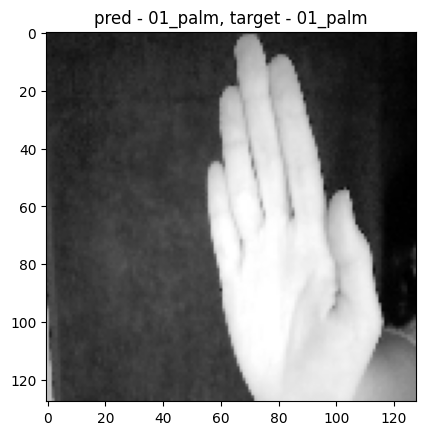

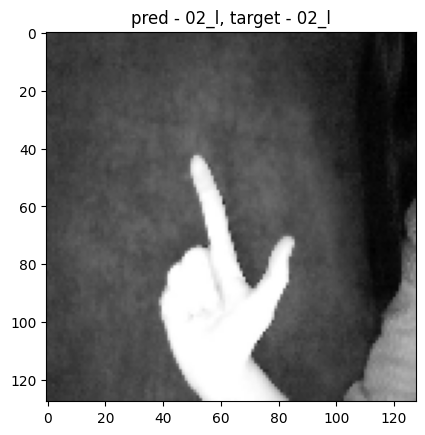

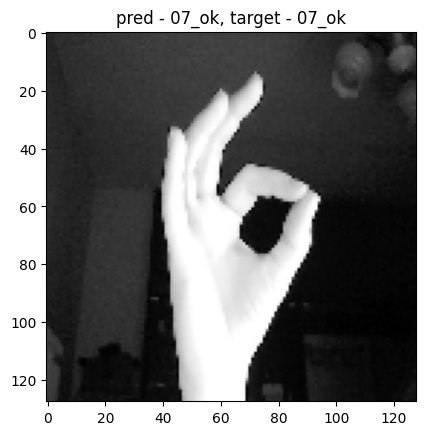

In [ ]:
with torch.no_grad():
    for i, data in enumerate(img_loader):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images.float())
        plt.title(f'pred - {classes_name[outputs[0].argmax()]}, target - {classes_name[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0))
        plt.show()
        if i>15:
            break

Модель правильно распознала класс на 3 из 4 фотографий. Первое изображение относится к 10 классу, модель предсказала 1 класс. Второе фото правильно распознано как 1 класс. Третье фото правильно распознано как 2 класс. Последнее изображение правильно распознано как 7 класс. Ошибка связана, вероятно, с тем, что изображения ладони (01) и движения ладонью вниз могут быть похожи (10) для модели.  Может быть и качество самого фото влияет на предсказание.

# Выводы

В работе был использован датасет для распознавания жестов рук, состоящий из набора изображений в ближнем инфракрасном диапазоне, полученных с помощью датчика Leap Motion. Датасет содержит 10 различных жестов рук (показаны выше), которые выполняли 10 разных людей (5 мужчин и 5 женщин).

Перед работой была выполнения аугментация данных для увеличения их разнообразия. Это помогло модели учиться более обобщённым признакам.
Для обучения использовалась модель resnet50, так как она сочетает высокую точность за счёт остаточных связей, преодолевающих проблему затухающих градиентов, с умеренными вычислительными затратами. Модель была взята с предобученными весами, последний слой был изменен для 10 классов.

После обучения модель была проверена на новых фотографиях, сделанных при помощи веб-камеры. Модель правильно распознала 3 из 4 фотографий. Это хороший результат. Возможно, для его улучшения необходимо более длительное обучение.
